In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
# mpl.style.use('ggplot')
sns.set_style('white')

In [2]:
df_train = pd.read_csv('input/training.csv')
df_test = pd.read_csv('input/test.csv')
df_lookid = pd.read_csv('input/IdLookupTable.csv')

In [3]:
print('Train data shape:', df_train.shape)
print('Test data shape:', df_test.shape)
print(df_train.info())
print(df_train.head().T)

BATCH_SIZE = 32
IMG_SIZE = (96, 96)

Train data shape: (7049, 31)
Test data shape: (1783, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          7039 non-null   float64
 1   left_eye_center_y          7039 non-null   float64
 2   right_eye_center_x         7036 non-null   float64
 3   right_eye_center_y         7036 non-null   float64
 4   left_eye_inner_corner_x    2271 non-null   float64
 5   left_eye_inner_corner_y    2271 non-null   float64
 6   left_eye_outer_corner_x    2267 non-null   float64
 7   left_eye_outer_corner_y    2267 non-null   float64
 8   right_eye_inner_corner_x   2268 non-null   float64
 9   right_eye_inner_corner_y   2268 non-null   float64
 10  right_eye_outer_corner_x   2268 non-null   float64
 11  right_eye_outer_corner_y   2268 non-null   float64
 12  left_eyebrow_inner_end_x   2270 non-null   float

<Axes: xlabel='value', ylabel='Count'>

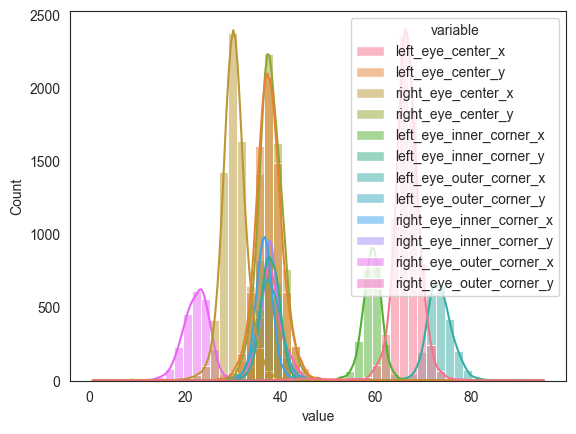

In [4]:
eye_cols = [col for col in df_train.columns if '_eye_' in col]
sns.histplot(data=df_train[eye_cols].melt(), x='value', hue='variable', kde=True, bins=50)

<Axes: xlabel='value', ylabel='Count'>

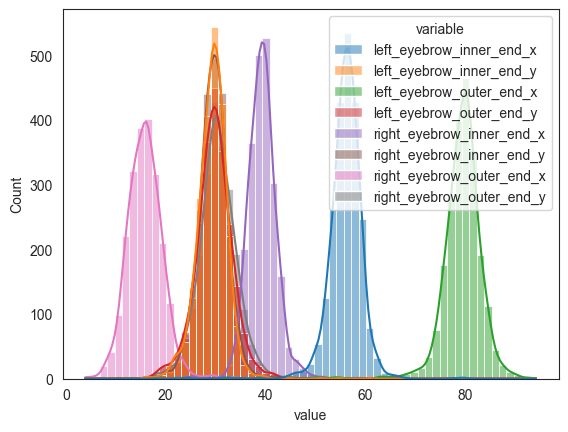

In [5]:
eyebrow_cols = [col for col in df_train.columns if '_eyebrow_' in col]
sns.histplot(data=df_train[eyebrow_cols].melt(), x='value', hue='variable', kde=True)


<Axes: xlabel='value', ylabel='Count'>

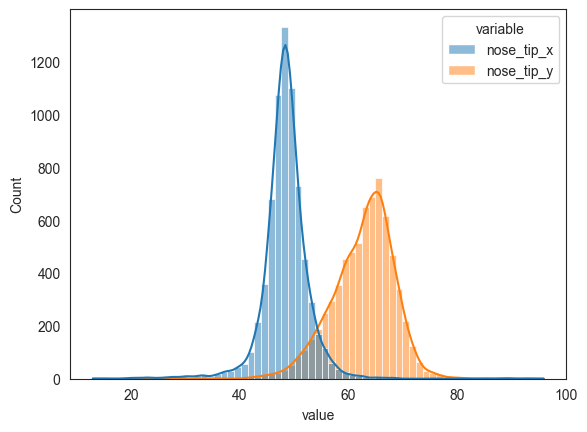

In [6]:
nose_cols = [col for col in df_train.columns if 'nose' in col]
sns.histplot(data=df_train[nose_cols].melt(), x='value', hue='variable', kde=True)

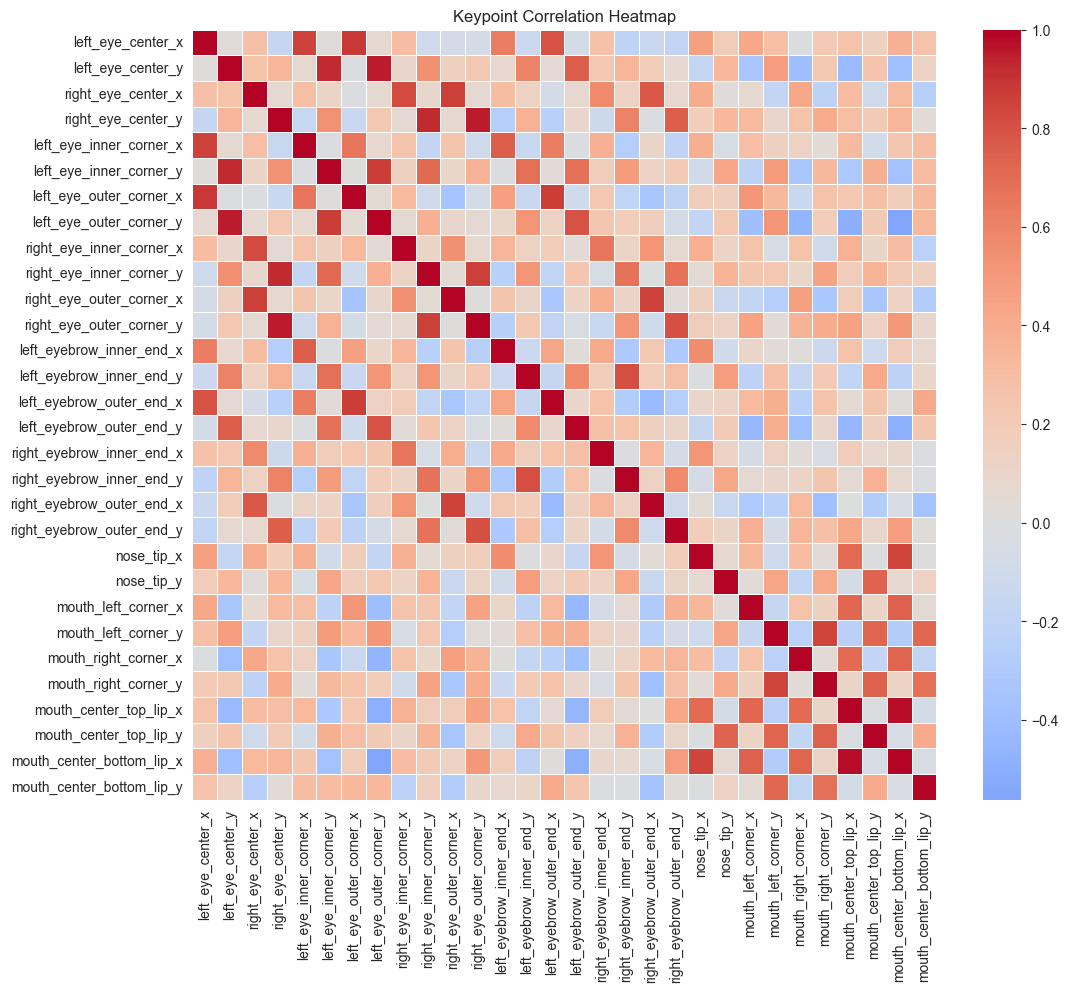

In [7]:
corr = df_train.drop(columns=['Image']).corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap='coolwarm', center=0, linewidths=0.5)
plt.title("Keypoint Correlation Heatmap")
plt.show()

In [8]:

##########################
### Data Preprocessing ###
##########################

#=== fill missing keypoints ===
df_train.ffill(inplace=True)  # Forward fill missing keypoints
print('Missing values after fill:', df_train.isnull().sum().sum())
# df_train_clean = df_train.dropna()  # Drop bad rows


#=== Parse image data ===
def parse_image(image_str):
	"""Convert a string of pixel values into a numpy array."""
	return np.fromstring(image_str, sep=' ').reshape(-1, *IMG_SIZE, 1).astype(np.float32) / 255.0
X_train = df_train['Image'].apply(parse_image)

X_train = np.vstack(X_train.values)
y_train = df_train.drop('Image', axis=1).values.astype(np.float32)  # Labels, shape: (num_samples, 30)

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)

Missing values after fill: 0
X_train shape: (7049, 96, 96, 1)
y_train shape: (7049, 30)


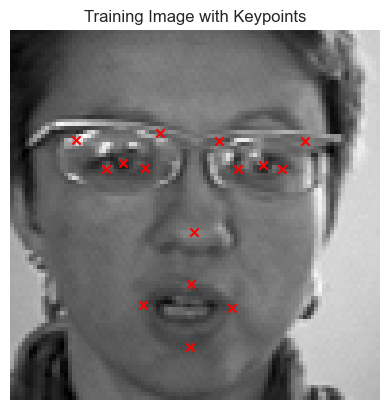

In [9]:
def plot(idx):
    image = X_train[idx].reshape(IMG_SIZE)  # Reshape to 2D for plotting
    
    keypoints = y_train[idx]
    
    # Plot
    plt.imshow(image, cmap='gray')
    plt.scatter(keypoints[0::2], keypoints[1::2], c='r', marker='x')  # every other is x, then y
    plt.title("Training Image with Keypoints")
    plt.axis('off')
    plt.show()

plot(10)

Augmented X shape: (32, 96, 96)
Augmented y shape: (32, 30)


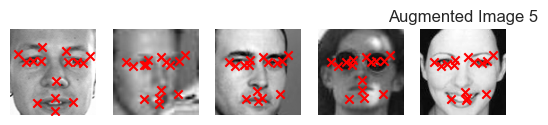

In [10]:

##########################
### Image Augmentation ###
##########################


def random_brightness_and_contrast(image, max_delta=0.1, lower=0.9, upper=1.1):
	"""Randomly adjust brightness and contrast of an image."""
	image = tf.image.random_brightness(image, max_delta=max_delta)
	image = tf.image.random_contrast(image, lower=lower, upper=upper)
	return image

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
	preprocessing_function=random_brightness_and_contrast,
	# rotation_range=20,
	# width_shift_range=0.2,
	# height_shift_range=0.2,
	# zoom_range=0.2,
	horizontal_flip=True,
	# fill_mode='nearest'
)
def augment_images(X, y, batch_size=BATCH_SIZE):
	"""Generate augmented images and keypoints."""
	# Reshape X to (num_samples, height, width, channels)
	X = X.reshape(-1, *IMG_SIZE, 1)
	
	# Create a generator
	generator = datagen.flow(X, y, batch_size=batch_size)
	
	while True:
		X_batch, y_batch = next(generator)
		yield X_batch.reshape(-1, *IMG_SIZE), y_batch  # Reshape back to original shape
# Example usage
augmented_gen = augment_images(X_train, y_train)
X_augmented, y_augmented = next(augmented_gen)
print('Augmented X shape:', X_augmented.shape)
print('Augmented y shape:', y_augmented.shape)
# Plot some augmented images
for i in range(5):
	plt.subplot(1, 5, i+1)
	plt.imshow(X_augmented[i].reshape(IMG_SIZE), cmap='gray')
	plt.scatter(y_augmented[i][0::2], y_augmented[i][1::2], c='r', marker='x')
	plt.axis('off')
plt.title(f"Augmented Image {i+1}")
plt.show()

In [11]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X_train,y_train,test_size=0.2,random_state=1)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5639, 96, 96, 1) (5639, 30)
(1410, 96, 96, 1) (1410, 30)


In [13]:
%%time
##############################
### NN Model Definition ###
##############################

model_NN = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 1)),  # Input shape: (height, width, channels)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(30)
])

model_NN.compile(optimizer='Adam', 
              loss='mse',
              metrics=['accuracy'])

history_NN = model_NN.fit(X_train, y_train, 
		  epochs = 50, batch_size = 16, validation_split = 0.2,
		  callbacks=[tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-7)]
        )




Epoch 1/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1553 - loss: 761.0861 - val_accuracy: 0.5479 - val_loss: 521.7664 - learning_rate: 0.0010
Epoch 2/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3332 - loss: 252.0372 - val_accuracy: 0.3635 - val_loss: 600.4944 - learning_rate: 0.0010
Epoch 3/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3839 - loss: 210.9180 - val_accuracy: 0.6135 - val_loss: 772.4686 - learning_rate: 0.0010
Epoch 4/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4145 - loss: 197.3141 - val_accuracy: 0.6206 - val_loss: 785.3517 - learning_rate: 0.0010
Epoch 5/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3929 - loss: 188.1719 - val_accuracy: 0.6135 - val_loss: 769.6373 - learning_rate: 0.0010
Epoch 6/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4648 - loss: 176.8305 - val_accuracy: 0.6055 - val_loss: 780.4484 - learning_rate: 0.0010
Epoch 7/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 

In [14]:
%%time
############################
### CNN Model Definition ###
############################

#= LeNet5-like CNN model for facial keypoints detection
#= Layer structure: Conv1 -> Conv2 -> 

model_CNN = tf.keras.models.Sequential([
	tf.keras.layers.Input(shape=(*IMG_SIZE, 1)),  # Input shape: (height, width, channels)

	tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
	tf.keras.layers.BatchNormalization(),
	tf.keras.layers.MaxPooling2D((2, 2)),

	tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
	tf.keras.layers.BatchNormalization(),
	tf.keras.layers.MaxPooling2D((2, 2)),

	tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
	tf.keras.layers.BatchNormalization(),
	tf.keras.layers.MaxPooling2D((2, 2)),

	tf.keras.layers.Flatten(),
	tf.keras.layers.Dense(256, activation='relu'),
	tf.keras.layers.Dropout(0.1),

	tf.keras.layers.Dense(30)  # Output layer for 30 keypoints
])

model_CNN.compile(optimizer='Adam', 
			  loss='mae',
			  metrics=['accuracy'])
history_CNN = model_CNN.fit(X_train, y_train, 
		  epochs = 50, batch_size = BATCH_SIZE, validation_split = 0.2,
		  callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
			tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-7)]
		)


Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 17s 112ms/step - accuracy: 0.2523 - loss: 10.7005 - val_accuracy: 8.8652e-04 - val_loss: 43.4475 - learning_rate: 0.0010
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 15s 108ms/step - accuracy: 0.3923 - loss: 5.3276 - val_accuracy: 0.5266 - val_loss: 38.2798 - learning_rate: 0.0010
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.4461 - loss: 4.5027 - val_accuracy: 0.6285 - val_loss: 30.2493 - learning_rate: 0.0010
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 15s 108ms/step - accuracy: 0.4749 - loss: 4.1954 - val_accuracy: 0.6817 - val_loss: 18.0121 - learning_rate: 0.0010
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 15s 109ms/step - accuracy: 0.4723 - loss: 4.0086 - val_accuracy: 0.6392 - val_loss: 7.1091 - learning_rate: 0.0010
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 15s 108ms/step - accuracy: 0.5441 - loss: 3.8143 - val_accuracy: 0.7190 - val_loss: 2.5889 - learning_rate: 0.0010
Epoch 7/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 15s 108ms/step - accu

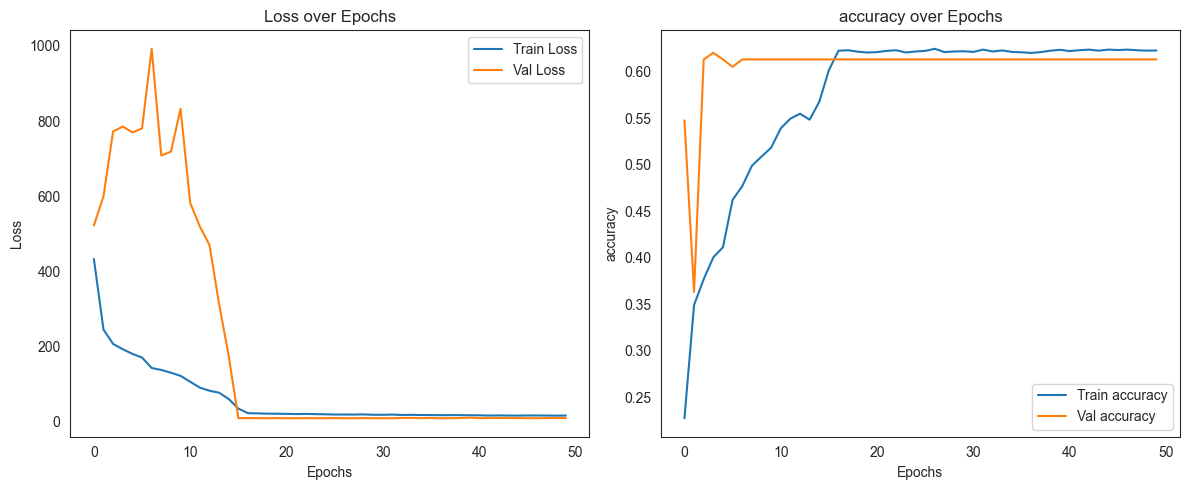

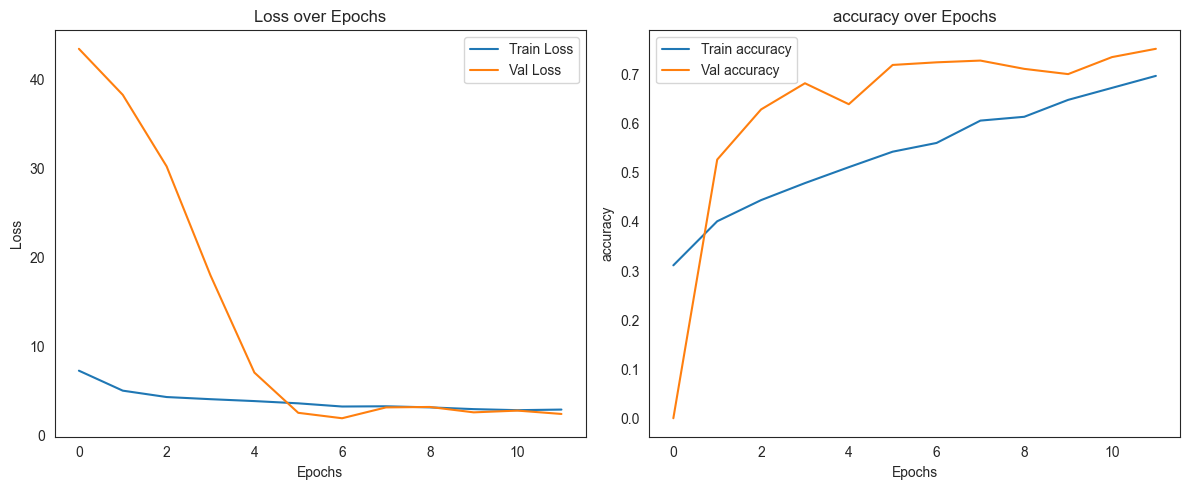

In [15]:
def plot_history(history):
    """Plot training and validation loss/MAE over epochs."""
    plt.figure(figsize=(12, 5))
    
    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train accuracy')
    plt.plot(history.history['val_accuracy'], label='Val accuracy')
    plt.title('accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
plot_history(history_NN)
plot_history(history_CNN)

In [16]:
###
### Prediction
###

X_test = df_test['Image'].apply(parse_image)
X_test = np.vstack(X_test.values)
print('X_test shape:', X_test.shape)
y_pred = model_CNN.predict(X_test)
print('y_pred shape:', y_pred.shape)


	

X_test shape: (1783, 96, 96, 1)
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
y_pred shape: (1783, 30)


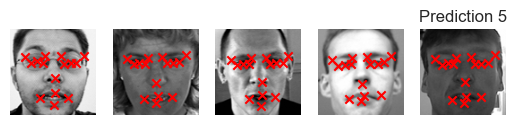

In [17]:
#Plot some predictions

for i in range(5):
	plt.subplot(1, 5, i+1)
	plt.imshow(X_test[i].reshape(IMG_SIZE), cmap='gray')
	plt.scatter(y_pred[i][0::2], y_pred[i][1::2], c='r', marker='x')
	plt.axis('off')

plt.title(f"Prediction {i+1}")
plt.show()

In [18]:
# Prepare submission DataFrame

feature_names = df_train.columns[:-1]
submission = df_lookid.copy()

for i, row in submission.iterrows():
    image_index = int(row['ImageId']) - 1  # ImageId starts at 1
    feature_name = row['FeatureName']
    feature_idx = feature_names.get_loc(feature_name)

    # Get the predicted value
    pred_value = y_pred[image_index][feature_idx]

    # Fill in Location
    submission.at[i, 'Location'] = pred_value

# Save submission file
submission_csv = submission[['RowId', 'Location']]
submission_csv.to_csv('output/submission.csv', index=False)
submission.head()

,RowId,ImageId,FeatureName,Location
0,1,1,left_eye_center_x,67.526642
1,2,1,left_eye_center_y,37.351135
2,3,1,right_eye_center_x,29.536312
3,4,1,right_eye_center_y,35.379330
4,5,1,left_eye_inner_corner_x,60.205776
